# Многослойные сети. Алгоритм обратного распространения ошибки




**Цель работы**: исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.

| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А.А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

Подключаем библиотеки, которые нам понадобятся в данной работе

In [3]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Этап 1

Создадим три тензора: тензор со значениями точек для первого эллипса, тензор со значениями точек для второго эллипса и тензор со значениями точек для параболы. Для получения точек будем использовать параметрическое уравнение эллипса (x = a * cos(phi),  y = b * sin(phi)) и параболы (y = (2 * p * x) ^ 0.5), добавив к ним значения смещений.

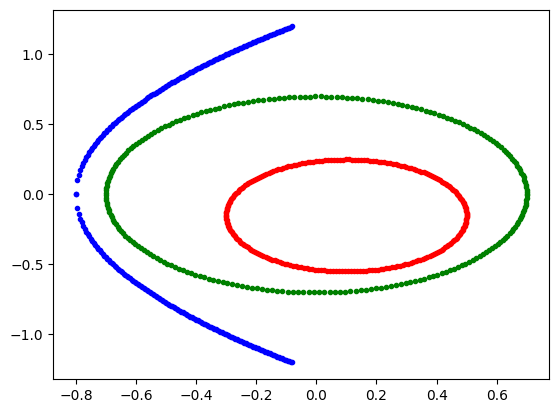

In [4]:
t = torch.arange(0, 2*torch.pi, 0.025)

a1 = 0.4
b1 = 0.4
alfa1 = 0
x01 = 0.1
y01 = -0.15

x_data1 = torch.Tensor([(torch.cos(phi+alfa1)*a1+x01,torch.sin(phi+alfa1)*b1+y01) for phi in t])

a2 = 0.7
b2 = 0.7
alfa2 = 0
x02 = 0
y02 = 0

x_data2 = torch.Tensor([(torch.cos(phi+alfa2)*a2+x02,torch.sin(phi+alfa2)*b2+y02) for phi in t])

t_3 = torch.arange(0, 0.8, 0.005)
p3 = 1
alfa3 = 0
x03 = -0.8
y03 = 0

y3_plus = [(x+x03, (2*p3*x)**0.5) for x in t_3 if (2*p3*x)**0.5<=1.2]
y3_minus = [(x+x03, -(2*p3*x)**0.5) for x in t_3 if (2*p3*x)**0.5<=1.2]
x_data3 = torch.Tensor(y3_plus+y3_minus)

plt.scatter(x_data1[:,0], x_data1[:,1], c="red", marker='.')
plt.scatter(x_data2[:,0], x_data2[:,1], c="green", marker='.')
plt.scatter(x_data3[:,0], x_data3[:,1], c="blue", marker='.')
plt.show()

Далее берём из каждого тензора соответственно 60, 100 и 120 случайных точек. Создадим массивы классов для каждой выборки: точка принадлежит первому множеству, если значения классов соответствуют значениям [1, 0, 0]. Аналогично для второго множества: [0, 1, 0]; и третьего множества: [0, 0, 1].

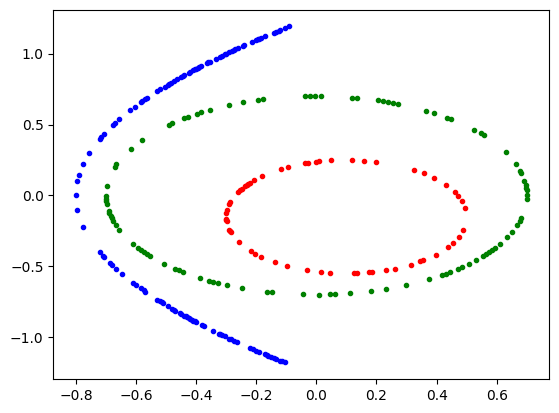

In [5]:
tmp = torch.randperm(x_data1.shape[0])
x_data1 = x_data1[tmp][:60,:]

one = torch.ones ((x_data1.shape[0],1))
zero = torch.zeros ((x_data1.shape[0],1))
y_data1 = torch.cat([one,zero,zero],dim=1)


tmp = torch.randperm(x_data2.shape[0])
x_data2 = x_data2[tmp][:100,:]

one = torch.ones ((x_data2.shape[0],1))
zero = torch.zeros ((x_data2.shape[0],1))
y_data2 = torch.cat([zero,one,zero],dim=1)


tmp = torch.randperm(x_data3.shape[0])
x_data3 = x_data3[tmp][:120,:]

one = torch.ones ((x_data3.shape[0],1))
zero = torch.zeros ((x_data3.shape[0],1))
y_data3 = torch.cat([zero,zero,one],dim=1)

plt.scatter(x_data1[:,0], x_data1[:,1], c="red", marker='.')
plt.scatter(x_data2[:,0], x_data2[:,1], c="green", marker='.')
plt.scatter(x_data3[:,0], x_data3[:,1], c="blue", marker='.')
plt.show()

Каждую выборку разделим на тестовую, валидационную и тренировочную и объединим их в три тензора: x_train, x_val, x_test.

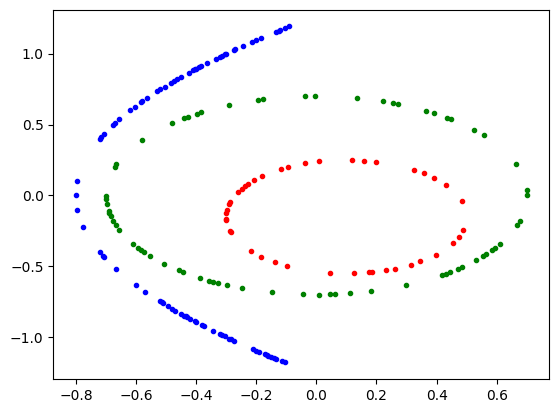

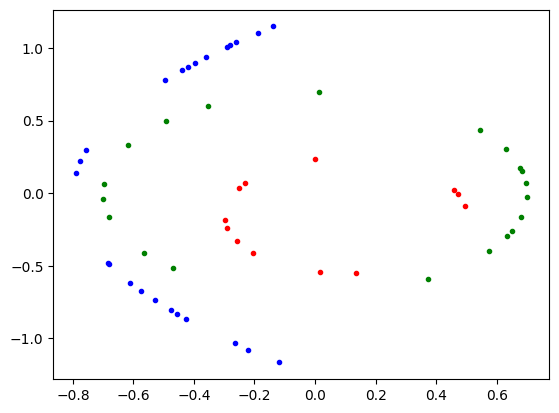

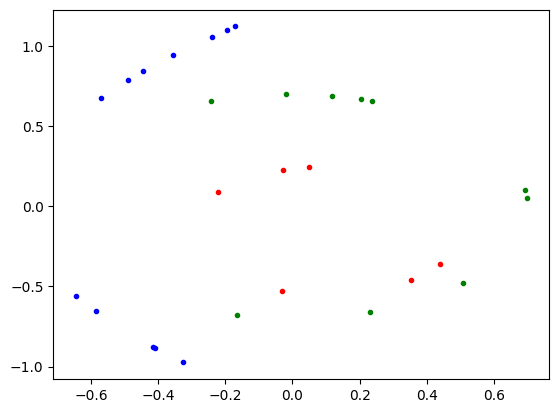

In [6]:
x_pretrain1, x_test1, y_train1, y_test1 = train_test_split(x_data1, y_data1, test_size=0.1)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_pretrain1, y_train1, test_size=0.222)

x_pretrain2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2, test_size=0.1)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_pretrain2, y_train2, test_size=0.222)

x_pretrain3, x_test3, y_train3, y_test3 = train_test_split(x_data3, y_data3, test_size=0.1)
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_pretrain3, y_train3, test_size=0.222)

x_train = torch.cat([x_train1,x_train2,x_train3],dim=0)
y_train = torch.cat([y_train1,y_train2,y_train3],dim=0)

x_val = torch.cat([x_val1,x_val2,x_val3],dim=0)
y_val = torch.cat([y_val1,y_val2,y_val3],dim=0)

x_test = torch.cat([x_test1,x_test2,x_test3],dim=0)
y_test = torch.cat([y_test1,y_test2,y_test3],dim=0)

tmp = torch.randperm(x_train.shape[0])
x_train = x_train[tmp]
y_train = y_train[tmp]

tmp = torch.randperm(x_val.shape[0])
x_val = x_val[tmp]
y_val = y_val[tmp]

tmp = torch.randperm(x_test.shape[0])
x_test = x_test[tmp]
y_test = y_test[tmp]



plt.scatter(x_train1[:,0], x_train1[:,1], c="red", marker='.')
plt.scatter(x_train2[:,0], x_train2[:,1], c="green", marker='.')
plt.scatter(x_train3[:,0], x_train3[:,1], c="blue", marker='.')
plt.show()
plt.scatter(x_val1[:,0], x_val1[:,1], c="red", marker='.')
plt.scatter(x_val2[:,0], x_val2[:,1], c="green", marker='.')
plt.scatter(x_val3[:,0], x_val3[:,1], c="blue", marker='.')
plt.show()
plt.scatter(x_test1[:,0], x_test1[:,1], c="red", marker='.')
plt.scatter(x_test2[:,0], x_test2[:,1], c="green", marker='.')
plt.scatter(x_test3[:,0], x_test3[:,1], c="blue", marker='.')
plt.show()

Задаём параметры линейного слоя

In [7]:
class Linear(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(inputs, outputs))
    self.bias = nn.Parameter(torch.randn(outputs))

  def forward(self, x):
    x = x @ self.weights + self.bias
    return x

Опишем класс Net нашей свёрточной сети. Она будет состоять из двух слоёв, первый из которых является скрытым. Количество нейронов зададим равным 20. В качестве функции активации будет использоваться Tanh.

In [8]:
Tanh = nn.Tanh()
class Net(nn.Module):
    def __init__(self, inputs, outputs):
        super(Net, self).__init__()
        self.l1 = Linear(inputs, 20)
        self.l2 = Linear(20, outputs)

    def forward(self, x):
      x = Tanh(self.l1(x))
      x = Tanh(self.l2(x))
      return x

Далее идёт класс Train, с помощью которого мы тренируем нашу сеть. Иницализируем класс параметрами обучения и определяем порядок обучения.

In [9]:
class Train():
  def __init__(self,  net, loss_f, learning_rate=1e-3, epoch_amount=10, optim=torch.optim.Adam):

    self.loss_f = loss_f
    self.learning_rate = learning_rate
    self.epoch_amount = epoch_amount
    self.optim = optim
    self.start_model = net
    self.best_model = net

    self.train_loss = []
    self.val_loss = []

  def predict(self, X):
    with torch.no_grad():
      return self.best_model(X)

  def fit(self, x_train, x_test, y_train, y_test):
    Net = self.start_model
    optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

    best_val_loss = float('inf')
    best_ep = 0

    with tqdm(desc="epoch", total=self.epoch_amount) as bar:
      for epoch in range(self.epoch_amount):
        optimizer.zero_grad()
        predicted_values = Net(x_train)
        loss1 = self.loss_f(predicted_values, y_train)
        loss1.backward()
        optimizer.step()

        self.train_loss.append(loss1.detach().numpy())

        with torch.no_grad():
          predicted_values = Net(x_test)
          loss2 = self.loss_f(predicted_values, y_test)

        self.val_loss.append(loss2.detach().numpy())
        bar.set_postfix({"Loss_train": loss1.detach().numpy(), "Loss_val": loss2.detach().numpy()})
        bar.update()

        if loss2 < best_val_loss:
          self.best_model = Net
          best_val_loss = loss2
          best_ep = epoch

Производим обучение модели. Количество входных данных сети: 2 (x, y); количество выходных данных сети: 3 ([{0, 1},{0, 1},{0, 1}]).

In [10]:
net = Net(2,3)
train = Train(net, nn.MSELoss(), 0.01, 1000, torch.optim.Rprop)
train.fit(x_train, x_val, y_train, y_val)

epoch: 100%|██████████| 1000/1000 [00:04<00:00, 235.29it/s, Loss_train=0.017126946, Loss_val=0.014913301]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

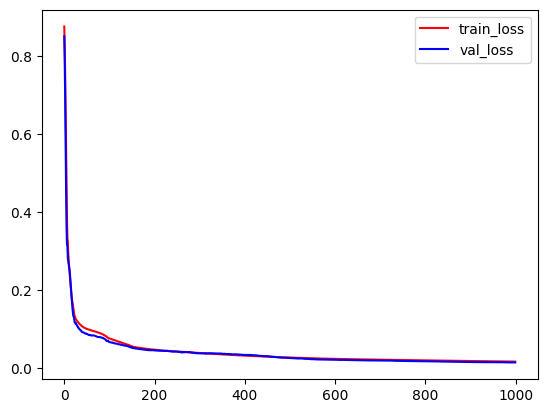

In [11]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.plot(train.val_loss, "blue", label='val_loss')
plt.legend()
plt.show()

Среднее значение ошибки на тестовой выборке получилось следующим:

In [12]:
print("test_loss: ", train.loss_f(train.predict(x_test), y_test).numpy())

test_loss:  0.010337296


Точки из тестовой выборки на графике

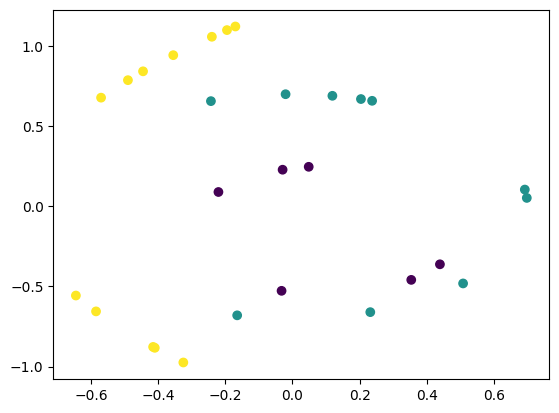

In [13]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=torch.argmax(train.predict(x_test), axis=1))
plt.show()

Проиллюстрируем на графике полученное распределение точек на классы

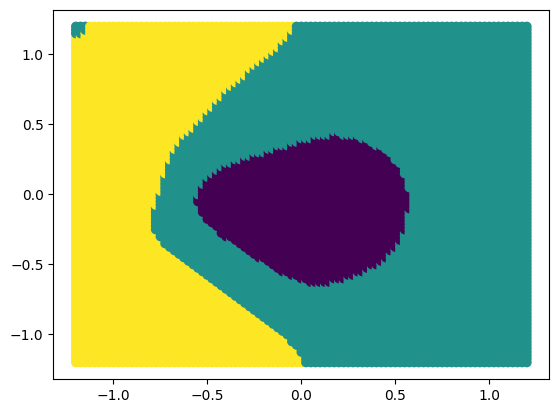

In [14]:
h = 0.025

xx = torch.Tensor([i for i in torch.arange(-1.2, 1.2 + h, h) for j in torch.arange(-1.2, 1.2 + h, h)])
yy = torch.Tensor([j for i in torch.arange(-1.2, 1.2 + h, h) for j in torch.arange(-1.2, 1.2 + h, h)])

predict = [torch.argmax(train.predict(torch.Tensor([xx[i], yy[i]])), axis=0) for i in range(xx.shape[0])]
plt.scatter(xx, yy, c=predict)
plt.show()

### Этап 2

Получим значения функции на заданном промежутке и разделим данные на тренировочную и валидационную. Отобразим полученные значения на графике.

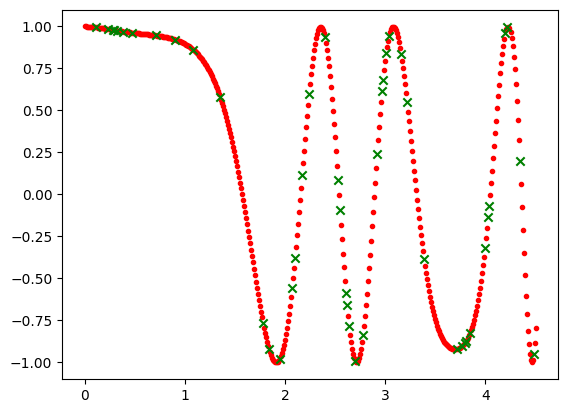

In [15]:
h = 0.01
x_data = torch.arange(0, 4.5+h, h).view(-1,1)
func = lambda t: torch.cos(torch.cos(t) * t * t - t)
y_data = torch.Tensor([func(a) for a in x_data]).view(-1,1)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

plt.scatter(x_train, y_train, c="red", marker='.')
plt.scatter(x_val, y_val, c="green", marker='x')
plt.show()

Изменим количество нейронов в нашей нейронной сети и активационную функцию для второго слоя.

In [16]:
Tanh = nn.Tanh()
class Net2(nn.Module):
    def __init__(self, inputs, outputs):
        super(Net2, self).__init__()
        self.l1 = Linear(inputs, 15)
        self.l2 = Linear(15, outputs)

    def forward(self, x):
      x = Tanh(self.l1(x))
      x = self.l2(x)
      return x

Обучим нашу модель, используя метод первого порядка

In [17]:
net = Net2(1,1)
train = Train(net, nn.MSELoss(), 0.1, 1000, torch.optim.Adagrad)
train.fit(x_train, x_val, y_train, y_val)

epoch: 100%|██████████| 1000/1000 [00:04<00:00, 248.85it/s, Loss_train=0.3036369, Loss_val=0.3615175]


Отобразим полученные значения ошибок и предсказанные значения на графике

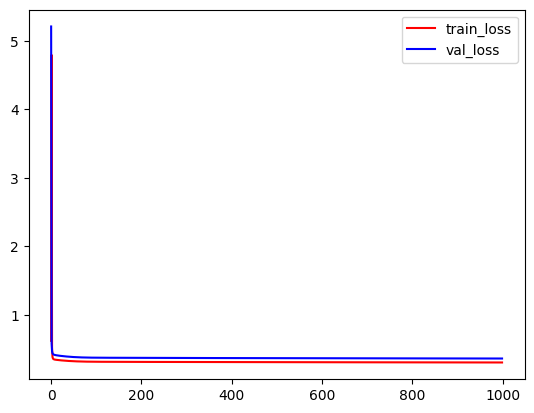

In [18]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.plot(train.val_loss, "blue", label='val_loss')
plt.legend()
plt.show()

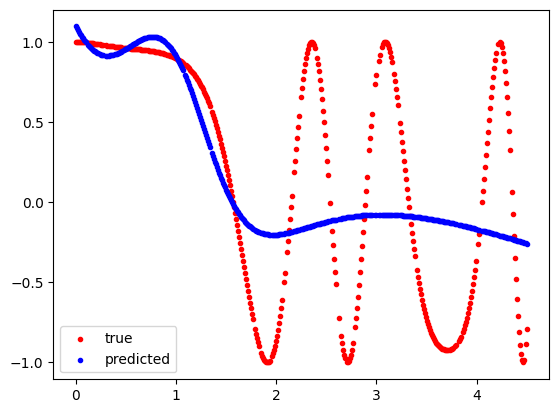

In [19]:
plt.scatter(x_train, y_train, c="red", label='true', marker='.')
plt.scatter(x_train, train.predict(x_train), c="blue", label='predicted', marker='.')
plt.legend()
plt.show()

### Этап 3

Создадим класс, в котором опишем метод второго порядка

In [38]:
class LevenbergMarquardtOptimizer():
    def __init__(self, function, initialPoint, gradient=None, jacobi=None, hessian=None,
                 interval=None, function_array=None, learningRate=1):
        self.learningRate = learningRate
        functionNew = lambda x: np.array([function(x)])
        super().__init__(functionNew, initialPoint, gradient, jacobi, hessian, interval, function_array=function_array)
        self.v = 2
        self.alpha = 1e-3
        self.m = self.alpha * np.max(self.getA(jacobi(initialPoint)))


    def getA(self, jacobi):
       return np.dot(jacobi.T, jacobi)

    def getF(self, d):
        function = self.function_array(d)
        return 0.5 * np.dot(function.T, function)

    def next_point(self):
        if self.y==0: # finished. Y can't be less than zero
            return self.x, self.y

        jacobi = self.jacobi(self.x)
        A = self.getA(jacobi)
        g = np.dot(jacobi.T, self.function_array(self.x)).reshape((-1, 1))
        leftPartInverse = np.linalg.inv(A + self.m * np.eye(A.shape[0], A.shape[1]))
        d_lm = - np.dot(leftPartInverse, g) # moving direction
        x_new = self.x + self.learningRate * d_lm.reshape((-1)) # line search
        grain_numerator = (self.getF(self.x) - self.getF(x_new))
        gain_divisor = 0.5* np.dot(d_lm.T, self.m*d_lm-g) + 1e-10
        gain = grain_numerator / gain_divisor
        if gain > 0: # it's a good function approximation.
            self.move_next(x_new) # ok, step acceptable
            self.m = self.m * max(1 / 3, 1 - (2 * gain - 1) ** 3)
            self.v = 2
        else:
            self.m *= self.v
            self.v *= 2
        return self.x, self.y

Обучим модель с помощью метода второго порядка

In [102]:
net = Net2(1,1)
train = Train(net, nn.MSELoss(), 0.1, 1000, LevenbergMarquardtOptimizer)
train.fit(x_train, x_val, y_train, y_val)

epoch: 100%|██████████| 1000/1000 [00:05<00:00, 193.86it/s, Loss_train=0.061377637, Loss_val=0.072171256]


Отобразим полученные значения ошибок и предсказанных значений на графике

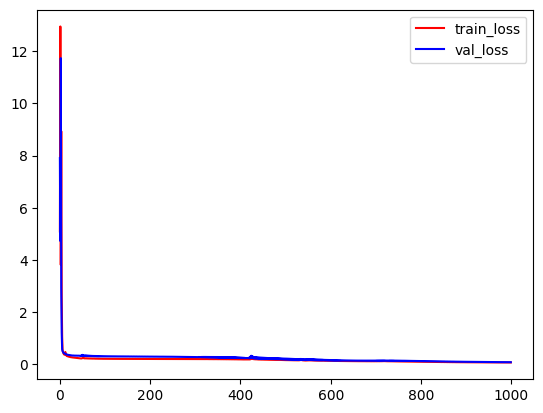

In [103]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.plot(train.val_loss, "blue", label='val_loss')
plt.legend()
plt.show()

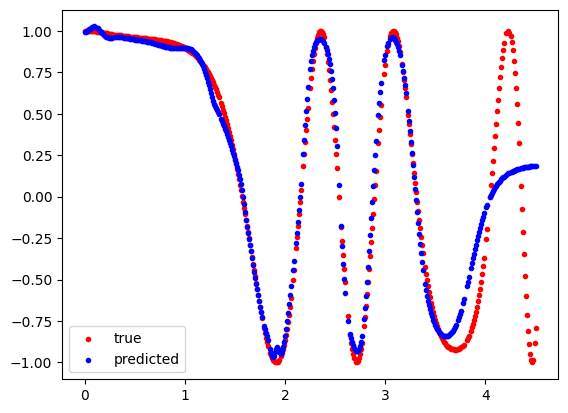

In [104]:
plt.scatter(x_train, y_train, c="red", label='true', marker='.')
plt.scatter(x_train, train.predict(x_train), c="blue", label='predicted', marker='.')
plt.legend()
plt.show()

**Вывод**: В процессе выполнения данной лабораторной работы я научился самостоятельно реализовывать и практически применять многослойные нейронные сети. Также я научился работать с методами первого и второго порядка. По результатам несложно заметить, что методы второго порядка позволяют существенно снизить значение ошибки в сравнении с методами первого порядка.